In [1]:
!curl -L -o ./archive.zip https://www.kaggle.com/api/v1/datasets/download/ananthu017/emotion-detection-fer
!unzip -q archive.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 65.1M  100 65.1M    0     0  31.7M      0  0:00:02  0:00:02 --:--:-- 55.9M


In [15]:
import numpy as np
import pandas as pd
import os
import re
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf

In [2]:
structured_datasets = {"train": {}, "test": {}}
directories = {"train": "./train", "test": "./test"}
for dataset, directory in directories.items():
  for dirpath, dirnames, filenames in os.walk(directory):
    for filename in filenames:
      if not (filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png")):
        continue

      full_path = os.path.join(dirpath, filename)
      img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)

      emotion = dirpath.split("/")[2]
      if emotion not in structured_datasets[dataset]:
        structured_datasets[dataset][emotion] = []

      structured_datasets[dataset][emotion].append(img)

In [3]:
labels = {
    emotion: i for i, emotion in enumerate(sorted(structured_datasets["train"].keys()))
}

In [4]:
x_train_py = []
y_train_py = []

for emotion, images in structured_datasets["train"].items():
  x_train_py.extend(images)
  output = [0, 0, 0, 0, 0, 0, 0]
  output[labels[emotion]] = 1
  y_train_py.extend([output for _ in range(len(images))])

x_test_py = []
y_test_py = []

for emotion, images in structured_datasets["test"].items():
  x_test_py.extend(images)
  output = [0, 0, 0, 0, 0, 0, 0]
  output[labels[emotion]] = 1
  y_test_py.extend([output for _ in range(len(images))])

x_train = np.array(x_train_py)
y_train = np.array(y_train_py)
x_test = np.array(x_test_py)
y_test = np.array(y_test_py)

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# More layers, less neurons

In [10]:
model = tf.keras.Sequential([
  tf.keras.layers.Input((48,48,1)),

  tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Conv2D(256,(3,3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=64
)

Epoch 1/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.1906 - loss: 2.5056 - val_accuracy: 0.2846 - val_loss: 1.7776
Epoch 2/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3023 - loss: 1.7969 - val_accuracy: 0.3476 - val_loss: 1.6640
Epoch 3/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3740 - loss: 1.6130 - val_accuracy: 0.4312 - val_loss: 1.4616
Epoch 4/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4232 - loss: 1.4990 - val_accuracy: 0.4260 - val_loss: 1.4686
Epoch 5/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.4476 - loss: 1.4263 - val_accuracy: 0.4552 - val_loss: 1.4281
Epoch 6/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.4779 - loss: 1.3704 - val_accuracy: 0.4305 - val_loss: 1.4564
Epoch 7/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4905 - loss: 1.3312 - val_accuracy: 0.5186 - val_loss: 1.2281
Epoch 8/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5062 - loss: 1.2977

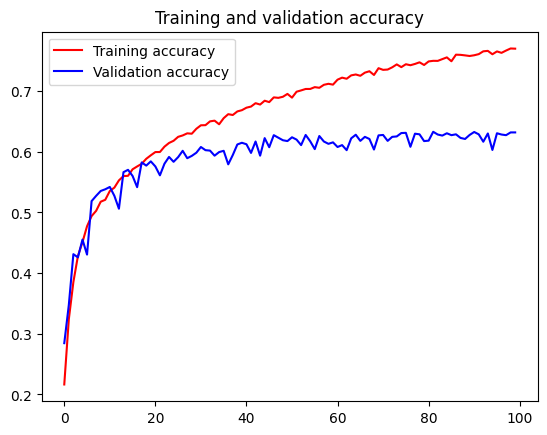

<Figure size 640x480 with 0 Axes>

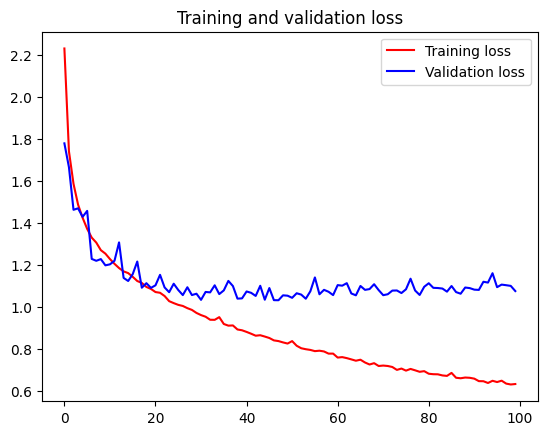

In [11]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
0.6471161883533018


<Axes: >

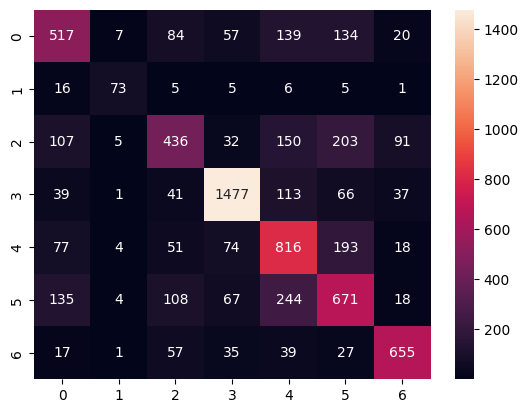

In [50]:
import seaborn as sn
y_pred: np.ndarray = model.predict(x_test)
y_pred = y_pred
conf_y_test = np.array([list(y).index(1) for y in y_test])
conf_y_pred = np.array([y.argmax(axis=0) for y in y_pred])
confmat = confusion_matrix(conf_y_test, conf_y_pred)
print(np.array(confmat).diagonal().sum() / np.array(confmat).sum())
sn.heatmap(confmat, annot=True, fmt="d")

# Less layers, more neurons

In [53]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Input((48,48,1)),

  tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Conv2D(1024,(5,5), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Dense(7, activation='softmax')
])

model2.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history2 = model2.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=64
)

Epoch 1/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 62s 122ms/step - accuracy: 0.3008 - loss: 2.1942 - val_accuracy: 0.4465 - val_loss: 1.4619
Epoch 2/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 60s 90ms/step - accuracy: 0.4329 - loss: 1.5139 - val_accuracy: 0.4619 - val_loss: 1.4142
Epoch 3/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.4830 - loss: 1.3669 - val_accuracy: 0.4145 - val_loss: 3.9885
Epoch 4/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.5052 - loss: 1.2997 - val_accuracy: 0.4817 - val_loss: 1.3965
Epoch 5/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 36s 89ms/step - accuracy: 0.5367 - loss: 1.2192 - val_accuracy: 0.5120 - val_loss: 1.2985
Epoch 6/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.5410 - loss: 1.2175 - val_accuracy: 0.4953 - val_loss: 1.4919
Epoch 7/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.5890 - loss: 1.1059 - val_accuracy: 0.4897 - val_loss: 1.5158
Epoch 8/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.5817 - loss: 

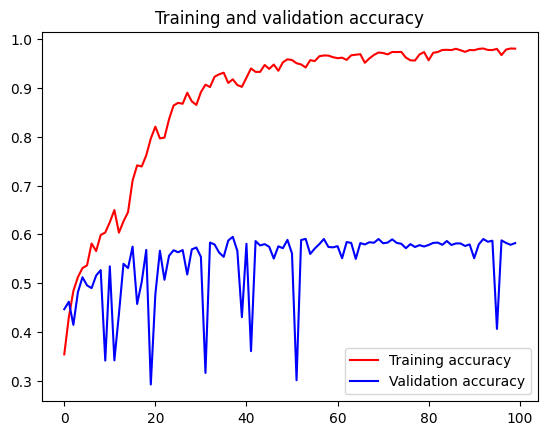

<Figure size 640x480 with 0 Axes>

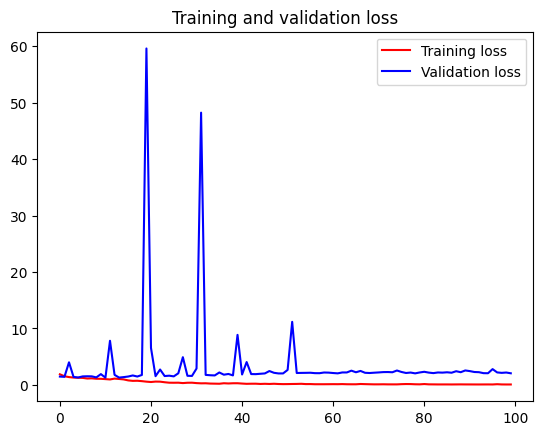

In [54]:
accuracy2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs2 = range(len(accuracy2))

plt.plot(epochs2, accuracy2, 'r', label='Training accuracy')
plt.plot(epochs2, val_acc2, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs2, loss2, 'r', label='Training loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
0.5787127333519086


<Axes: >

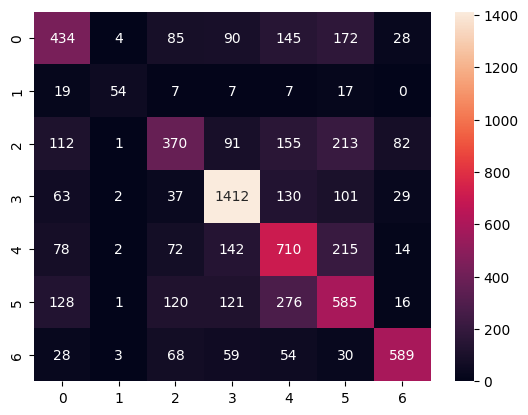

In [55]:
import seaborn as sn
y_pred2: np.ndarray = model2.predict(x_test)
y_pred2 = y_pred2
conf_y_test = np.array([list(y).index(1) for y in y_test])
conf_y_pred2 = np.array([y.argmax(axis=0) for y in y_pred2])
confmat2 = confusion_matrix(conf_y_test, conf_y_pred2)
print(labels)
print(np.array(confmat2).diagonal().sum() / np.array(confmat2).sum())
sn.heatmap(confmat2, annot=True, fmt="d")


In [58]:
x_me_neutral = np.array([cv2.imread("./me_neutral.png", cv2.IMREAD_GRAYSCALE)])
x_me_happy = np.array([cv2.imread("./me_happy.png", cv2.IMREAD_GRAYSCALE)])

l_me_neutral = model.predict(x_me_neutral)[0].argmax(axis=0)
l_me_happy = model.predict(x_me_happy)[0].argmax(axis=0)
print("Model 1 (Neutral):", [k for k, v in labels.items() if v == l_me_neutral])
print("Model 1 (Happy):", [k for k, v in labels.items() if v == l_me_happy])

l_me_neutral2 = model2.predict(x_me_neutral)[0].argmax(axis=0)
l_me_happy2 = model2.predict(x_me_happy)[0].argmax(axis=0)
print("Model 2 (Neutral):", [k for k, v in labels.items() if v == l_me_neutral2])
print("Model 2 (Happy):", [k for k, v in labels.items() if v == l_me_happy2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Model 1 (Neutral): ['neutral']
Model 1 (Happy): ['happy']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Model 2 (Neutral): ['neutral']
Model 2 (Happy): ['happy']
